In [1]:
from util import api_hook as ap
import nest_asyncio
nest_asyncio.apply()  # Allo
api_key="362de69bbf9e42f7b9e41b6563dee0a2"
api="https://newsapi.org/v2/everything?q=tesla&from=2025-02-09&sortBy=publishedAt&apiKey="

In [2]:
fetch =ap(output_path="fetched_data.json")
fetch.run(f"{api}{api_key}")

Data saved to fetched_data.json


# WORD

In [3]:
import json
import pandas as pd
from model import SkipGramModel
from util import createPairs
import nltk
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

with open("fetched_data.json", "r") as file:
    json_data = json.load(file)
df = pd.json_normalize(json_data['articles'])
df.head(1)

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
0,Frode Wikesjö,Årets STCC-säsong läggs på is,Siktar på comeback 2026\n\n\n\n\n\n\nDen klass...,https://feber.se/samhalle/arets-stcc-sasong-la...,https://static.feber.se/article_images/61/28/5...,2025-03-08T08:00:00Z,4 idag\r\nVälkommen till Feber\r\nSkaffa Feber...,None,Feber.se


In [5]:
df.drop(labels=['urlToImage','publishedAt','source.id','source.name','url','author'],axis=1,inplace=True)

In [6]:
pairs =  createPairs(df,drop=True)
vocab,word_pairs = pairs.get_vocab_and_pairs(column='content')

In [7]:
word_pairs,vocab

([('representative', 'gilbert'),
  ('gilbert', 'representative'),
  ('gilbert', 'ray'),
  ('ray', 'gilbert'),
  ('ray', 'cisneros'),
  ('cisneros', 'ray'),
  ('cisneros', 'jr'),
  ('jr', 'cisneros'),
  ('jr', 'dcalifornia'),
  ('dcalifornia', 'jr'),
  ('dcalifornia', 'recently'),
  ('recently', 'dcalifornia'),
  ('recently', 'bought'),
  ('bought', 'recently'),
  ('bought', 'shares'),
  ('shares', 'bought'),
  ('shares', 'tesla'),
  ('tesla', 'shares'),
  ('tesla', 'inc'),
  ('inc', 'tesla'),
  ('inc', 'nasdaqtsla'),
  ('nasdaqtsla', 'inc'),
  ('nasdaqtsla', 'filing'),
  ('filing', 'nasdaqtsla'),
  ('filing', 'disclosed'),
  ('disclosed', 'filing'),
  ('disclosed', 'march'),
  ('march', 'disclosed'),
  ('march', 'th'),
  ('th', 'march'),
  ('th', 'representative'),
  ('representative', 'th'),
  ('representative', 'disclosed'),
  ('disclosed', 'representative'),
  ('disclosed', 'bought'),
  ('bought', 'disclosed'),
  ('bought', 'bet'),
  ('bet', 'bought'),
  ('bet', 'chars'),
  ('chars'

In [10]:
model =SkipGramModel(vocab_size=len(vocab),embedding_dim=300)

In [11]:

def plot_embeddings_tsne(embeddings, words_to_plot=None):
    if words_to_plot:
        selected_embeddings = {word: embeddings[word] for word in words_to_plot if word in embeddings}
    else:
        selected_embeddings = embeddings
    words = list(selected_embeddings.keys())
    vectors = np.array([selected_embeddings[word] for word in words])
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], edgecolors='k', c='r')
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
    plt.title('Word Embeddings Visualized with t-SNE')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()
def compute_cosine_similarity(embeddings):
    words = list(embeddings.keys())
    vectors = np.array([embeddings[word] for word in words])
    similarity_matrix = cosine_similarity(vectors)
    similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
    return similarity_df
def get_top_n_similar(similarity_df, word, top_n=5):
    if word not in similarity_df.columns:
        raise ValueError(f"Word '{word}' not found in similarity matrix.")
    sorted_similarities = similarity_df[word].sort_values(ascending=False)
    top_similar = sorted_similarities.drop(labels=[word]).head(top_n)
    return list(zip(top_similar.index, top_similar.values))
def extract_embeddings(model, word2idx):
    embeddings = {}
    for word, idx in word2idx.items():
        embeddings[word] = model.W1[idx]
    return embeddings




In [12]:
def train_example(vocab, training_pairs, epochs, learning_rate=0.01):
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    model = SkipGramModel(vocab_size=len(vocab), embedding_dim=20)
    loss_history = []
    if not isinstance(training_pairs, list):
        training_pairs = list(training_pairs)
    total_pairs = len(training_pairs)  # Total number of training pairs
    for epoch in range(1, epochs + 1):
        total_loss = 0  # Reset total loss for the current epoch
        with tqdm(total=total_pairs, desc=f"Epoch {epoch}/{epochs}", unit="pair") as pbar:
            for i, (target_word, context_word) in enumerate(training_pairs, start=1):
                target_vector = np.zeros(len(vocab))
                target_vector[word2idx[target_word]] = 1
                context_vector = np.zeros(len(vocab))
                context_vector[word2idx[context_word]] = 1
                hidden, output = model.forward(target_vector)
                epsilon = 1e-10 
                loss = -np.log(output[word2idx[context_word]] + epsilon)
                model.backward(target_vector, context_vector, learning_rate=learning_rate)
                total_loss += loss
                if i % 20 == 0:
                    pbar.update(20)  
                    pbar.set_postfix(loss=loss)  
            remainder = total_pairs % 20
            if remainder != 0:
                pbar.update(remainder)
                pbar.set_postfix(loss=loss)
        average_loss = total_loss / total_pairs
        loss_history.append(average_loss)
        print(f"Epoch {epoch}/{epochs}, Average Loss: {average_loss:.6f}")
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), loss_history, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()
    
    return model, word2idx

Epoch 1/100: 100%|██████████| 2720/2720 [00:00<00:00, 6740.91pair/s, loss=6.59]


Epoch 1/100, Average Loss: 6.587393


Epoch 2/100: 100%|██████████| 2720/2720 [00:00<00:00, 7591.06pair/s, loss=6.59]


Epoch 2/100, Average Loss: 6.583819


Epoch 3/100: 100%|██████████| 2720/2720 [00:00<00:00, 7434.45pair/s, loss=6.59]


Epoch 3/100, Average Loss: 6.491946


Epoch 4/100: 100%|██████████| 2720/2720 [00:00<00:00, 6952.97pair/s, loss=6.59]


Epoch 4/100, Average Loss: 6.042166


Epoch 5/100: 100%|██████████| 2720/2720 [00:00<00:00, 6859.74pair/s, loss=6.51]


Epoch 5/100, Average Loss: 5.666060


Epoch 6/100: 100%|██████████| 2720/2720 [00:00<00:00, 7263.83pair/s, loss=6.26] 


Epoch 6/100, Average Loss: 5.481917


Epoch 7/100: 100%|██████████| 2720/2720 [00:00<00:00, 6972.27pair/s, loss=5.79] 


Epoch 7/100, Average Loss: 5.314106


Epoch 8/100: 100%|██████████| 2720/2720 [00:00<00:00, 7358.82pair/s, loss=5.24] 


Epoch 8/100, Average Loss: 5.117421


Epoch 9/100: 100%|██████████| 2720/2720 [00:00<00:00, 6977.71pair/s, loss=4.81] 


Epoch 9/100, Average Loss: 4.889898


Epoch 10/100: 100%|██████████| 2720/2720 [00:00<00:00, 7048.07pair/s, loss=4.54] 


Epoch 10/100, Average Loss: 4.644230


Epoch 11/100: 100%|██████████| 2720/2720 [00:00<00:00, 7028.05pair/s, loss=4.32] 


Epoch 11/100, Average Loss: 4.418904


Epoch 12/100: 100%|██████████| 2720/2720 [00:00<00:00, 7351.31pair/s, loss=4.11] 


Epoch 12/100, Average Loss: 4.202857


Epoch 13/100: 100%|██████████| 2720/2720 [00:00<00:00, 7133.17pair/s, loss=3.87] 


Epoch 13/100, Average Loss: 3.993177


Epoch 14/100: 100%|██████████| 2720/2720 [00:00<00:00, 6814.85pair/s, loss=3.65]


Epoch 14/100, Average Loss: 3.794357


Epoch 15/100: 100%|██████████| 2720/2720 [00:00<00:00, 7382.37pair/s, loss=3.45] 


Epoch 15/100, Average Loss: 3.613728


Epoch 16/100: 100%|██████████| 2720/2720 [00:00<00:00, 7256.31pair/s, loss=3.3]  


Epoch 16/100, Average Loss: 3.454095


Epoch 17/100: 100%|██████████| 2720/2720 [00:00<00:00, 7443.59pair/s, loss=3.23] 


Epoch 17/100, Average Loss: 3.310483


Epoch 18/100: 100%|██████████| 2720/2720 [00:00<00:00, 6893.68pair/s, loss=3.31] 


Epoch 18/100, Average Loss: 3.178613


Epoch 19/100: 100%|██████████| 2720/2720 [00:00<00:00, 7242.43pair/s, loss=3.54] 


Epoch 19/100, Average Loss: 3.057094


Epoch 20/100: 100%|██████████| 2720/2720 [00:00<00:00, 7174.56pair/s, loss=3.76] 


Epoch 20/100, Average Loss: 2.944946


Epoch 21/100: 100%|██████████| 2720/2720 [00:00<00:00, 7066.67pair/s, loss=3.93] 


Epoch 21/100, Average Loss: 2.839746


Epoch 22/100: 100%|██████████| 2720/2720 [00:00<00:00, 7612.26pair/s, loss=4.06] 


Epoch 22/100, Average Loss: 2.740446


Epoch 23/100: 100%|██████████| 2720/2720 [00:00<00:00, 6983.79pair/s, loss=4.15] 


Epoch 23/100, Average Loss: 2.647079


Epoch 24/100: 100%|██████████| 2720/2720 [00:00<00:00, 7328.50pair/s, loss=4.23] 


Epoch 24/100, Average Loss: 2.560004


Epoch 25/100: 100%|██████████| 2720/2720 [00:00<00:00, 7388.05pair/s, loss=4.28] 


Epoch 25/100, Average Loss: 2.479141


Epoch 26/100: 100%|██████████| 2720/2720 [00:00<00:00, 6930.55pair/s, loss=4.32] 


Epoch 26/100, Average Loss: 2.403989


Epoch 27/100: 100%|██████████| 2720/2720 [00:00<00:00, 7298.64pair/s, loss=4.34] 


Epoch 27/100, Average Loss: 2.334300


Epoch 28/100: 100%|██████████| 2720/2720 [00:00<00:00, 7400.56pair/s, loss=4.34] 


Epoch 28/100, Average Loss: 2.270487


Epoch 29/100: 100%|██████████| 2720/2720 [00:00<00:00, 6906.60pair/s, loss=4.33] 


Epoch 29/100, Average Loss: 2.213575


Epoch 30/100: 100%|██████████| 2720/2720 [00:00<00:00, 7038.41pair/s, loss=4.32] 


Epoch 30/100, Average Loss: 2.164882


Epoch 31/100: 100%|██████████| 2720/2720 [00:00<00:00, 7522.00pair/s, loss=4.3]  


Epoch 31/100, Average Loss: 2.125497


Epoch 32/100: 100%|██████████| 2720/2720 [00:00<00:00, 6999.87pair/s, loss=4.29] 


Epoch 32/100, Average Loss: 2.095535


Epoch 33/100: 100%|██████████| 2720/2720 [00:00<00:00, 7463.37pair/s, loss=4.28] 


Epoch 33/100, Average Loss: 2.074038


Epoch 34/100: 100%|██████████| 2720/2720 [00:00<00:00, 7380.21pair/s, loss=4.26] 


Epoch 34/100, Average Loss: 2.059405


Epoch 35/100: 100%|██████████| 2720/2720 [00:00<00:00, 7312.56pair/s, loss=4.25] 


Epoch 35/100, Average Loss: 2.049877


Epoch 36/100: 100%|██████████| 2720/2720 [00:00<00:00, 7447.00pair/s, loss=4.23] 


Epoch 36/100, Average Loss: 2.043942


Epoch 37/100: 100%|██████████| 2720/2720 [00:00<00:00, 7140.79pair/s, loss=4.21] 


Epoch 37/100, Average Loss: 2.040525


Epoch 38/100: 100%|██████████| 2720/2720 [00:00<00:00, 6856.41pair/s, loss=4.2]  


Epoch 38/100, Average Loss: 2.038920


Epoch 39/100: 100%|██████████| 2720/2720 [00:00<00:00, 7277.04pair/s, loss=4.19] 


Epoch 39/100, Average Loss: 2.038645


Epoch 40/100: 100%|██████████| 2720/2720 [00:00<00:00, 7341.42pair/s, loss=4.19] 


Epoch 40/100, Average Loss: 2.039343


Epoch 41/100: 100%|██████████| 2720/2720 [00:00<00:00, 6963.60pair/s, loss=4.19] 


Epoch 41/100, Average Loss: 2.040761


Epoch 42/100: 100%|██████████| 2720/2720 [00:00<00:00, 7181.35pair/s, loss=4.19] 


Epoch 42/100, Average Loss: 2.042715


Epoch 43/100: 100%|██████████| 2720/2720 [00:00<00:00, 7117.10pair/s, loss=4.2]  


Epoch 43/100, Average Loss: 2.045071


Epoch 44/100: 100%|██████████| 2720/2720 [00:00<00:00, 7048.15pair/s, loss=4.2]  


Epoch 44/100, Average Loss: 2.047692


Epoch 45/100: 100%|██████████| 2720/2720 [00:00<00:00, 7014.27pair/s, loss=4.21] 


Epoch 45/100, Average Loss: 2.050456


Epoch 46/100: 100%|██████████| 2720/2720 [00:00<00:00, 6961.56pair/s, loss=4.22] 


Epoch 46/100, Average Loss: 2.053318


Epoch 47/100: 100%|██████████| 2720/2720 [00:00<00:00, 7119.89pair/s, loss=4.22] 


Epoch 47/100, Average Loss: 2.056262


Epoch 48/100: 100%|██████████| 2720/2720 [00:00<00:00, 7115.47pair/s, loss=4.23] 


Epoch 48/100, Average Loss: 2.059339


Epoch 49/100: 100%|██████████| 2720/2720 [00:00<00:00, 6990.43pair/s, loss=4.24] 


Epoch 49/100, Average Loss: 2.062514


Epoch 50/100: 100%|██████████| 2720/2720 [00:00<00:00, 7439.03pair/s, loss=4.25] 


Epoch 50/100, Average Loss: 2.065726


Epoch 51/100: 100%|██████████| 2720/2720 [00:00<00:00, 6935.46pair/s, loss=4.26] 


Epoch 51/100, Average Loss: 2.068922


Epoch 52/100: 100%|██████████| 2720/2720 [00:00<00:00, 6965.44pair/s, loss=4.27] 


Epoch 52/100, Average Loss: 2.072105


Epoch 53/100: 100%|██████████| 2720/2720 [00:00<00:00, 6897.07pair/s, loss=4.28] 


Epoch 53/100, Average Loss: 2.075243


Epoch 54/100: 100%|██████████| 2720/2720 [00:00<00:00, 6852.20pair/s, loss=4.29] 


Epoch 54/100, Average Loss: 2.078275


Epoch 55/100: 100%|██████████| 2720/2720 [00:00<00:00, 6772.34pair/s, loss=4.31] 


Epoch 55/100, Average Loss: 2.081221


Epoch 56/100: 100%|██████████| 2720/2720 [00:00<00:00, 7084.69pair/s, loss=4.32] 


Epoch 56/100, Average Loss: 2.084084


Epoch 57/100: 100%|██████████| 2720/2720 [00:00<00:00, 6824.22pair/s, loss=4.34] 


Epoch 57/100, Average Loss: 2.086846


Epoch 58/100: 100%|██████████| 2720/2720 [00:00<00:00, 6773.60pair/s, loss=4.36] 


Epoch 58/100, Average Loss: 2.089576


Epoch 59/100: 100%|██████████| 2720/2720 [00:00<00:00, 7093.65pair/s, loss=4.38] 


Epoch 59/100, Average Loss: 2.092281


Epoch 60/100: 100%|██████████| 2720/2720 [00:00<00:00, 7353.77pair/s, loss=4.4]  


Epoch 60/100, Average Loss: 2.094931


Epoch 61/100: 100%|██████████| 2720/2720 [00:00<00:00, 6525.12pair/s, loss=4.42] 


Epoch 61/100, Average Loss: 2.097536


Epoch 62/100: 100%|██████████| 2720/2720 [00:00<00:00, 7165.88pair/s, loss=4.44] 


Epoch 62/100, Average Loss: 2.100091


Epoch 63/100: 100%|██████████| 2720/2720 [00:00<00:00, 7137.07pair/s, loss=4.46] 


Epoch 63/100, Average Loss: 2.102602


Epoch 64/100: 100%|██████████| 2720/2720 [00:00<00:00, 7199.40pair/s, loss=4.48] 


Epoch 64/100, Average Loss: 2.105056


Epoch 65/100: 100%|██████████| 2720/2720 [00:00<00:00, 6647.73pair/s, loss=4.51]


Epoch 65/100, Average Loss: 2.107433


Epoch 66/100: 100%|██████████| 2720/2720 [00:00<00:00, 6751.02pair/s, loss=4.53] 


Epoch 66/100, Average Loss: 2.109730


Epoch 67/100: 100%|██████████| 2720/2720 [00:00<00:00, 7078.89pair/s, loss=4.55] 


Epoch 67/100, Average Loss: 2.111977


Epoch 68/100: 100%|██████████| 2720/2720 [00:00<00:00, 6901.96pair/s, loss=4.58] 


Epoch 68/100, Average Loss: 2.114186


Epoch 69/100: 100%|██████████| 2720/2720 [00:00<00:00, 6816.56pair/s, loss=4.6]  


Epoch 69/100, Average Loss: 2.116387


Epoch 70/100: 100%|██████████| 2720/2720 [00:00<00:00, 6921.65pair/s, loss=4.63] 


Epoch 70/100, Average Loss: 2.118561


Epoch 71/100: 100%|██████████| 2720/2720 [00:00<00:00, 6936.85pair/s, loss=4.66] 


Epoch 71/100, Average Loss: 2.120710


Epoch 72/100: 100%|██████████| 2720/2720 [00:00<00:00, 7495.96pair/s, loss=4.69] 


Epoch 72/100, Average Loss: 2.122827


Epoch 73/100: 100%|██████████| 2720/2720 [00:00<00:00, 6841.39pair/s, loss=4.72] 


Epoch 73/100, Average Loss: 2.124906


Epoch 74/100: 100%|██████████| 2720/2720 [00:00<00:00, 7148.64pair/s, loss=4.74] 


Epoch 74/100, Average Loss: 2.126999


Epoch 75/100: 100%|██████████| 2720/2720 [00:00<00:00, 7033.77pair/s, loss=4.77] 


Epoch 75/100, Average Loss: 2.129135


Epoch 76/100: 100%|██████████| 2720/2720 [00:00<00:00, 6827.68pair/s, loss=4.79] 


Epoch 76/100, Average Loss: 2.131289


Epoch 77/100: 100%|██████████| 2720/2720 [00:00<00:00, 6925.36pair/s, loss=4.81] 


Epoch 77/100, Average Loss: 2.133417


Epoch 78/100: 100%|██████████| 2720/2720 [00:00<00:00, 7090.23pair/s, loss=4.83] 


Epoch 78/100, Average Loss: 2.135488


Epoch 79/100: 100%|██████████| 2720/2720 [00:00<00:00, 6870.13pair/s, loss=4.85] 


Epoch 79/100, Average Loss: 2.137487


Epoch 80/100: 100%|██████████| 2720/2720 [00:00<00:00, 7067.80pair/s, loss=4.86] 


Epoch 80/100, Average Loss: 2.139409


Epoch 81/100: 100%|██████████| 2720/2720 [00:00<00:00, 6890.77pair/s, loss=4.88] 


Epoch 81/100, Average Loss: 2.141280


Epoch 82/100: 100%|██████████| 2720/2720 [00:00<00:00, 6842.95pair/s, loss=4.89] 


Epoch 82/100, Average Loss: 2.143113


Epoch 83/100: 100%|██████████| 2720/2720 [00:00<00:00, 6879.81pair/s, loss=4.9]  


Epoch 83/100, Average Loss: 2.144929


Epoch 84/100: 100%|██████████| 2720/2720 [00:00<00:00, 6587.30pair/s, loss=4.91] 


Epoch 84/100, Average Loss: 2.146726


Epoch 85/100: 100%|██████████| 2720/2720 [00:00<00:00, 7048.06pair/s, loss=4.92] 


Epoch 85/100, Average Loss: 2.148487


Epoch 86/100: 100%|██████████| 2720/2720 [00:00<00:00, 7180.31pair/s, loss=4.93] 


Epoch 86/100, Average Loss: 2.150213


Epoch 87/100: 100%|██████████| 2720/2720 [00:00<00:00, 6766.43pair/s, loss=4.93] 


Epoch 87/100, Average Loss: 2.151922


Epoch 88/100: 100%|██████████| 2720/2720 [00:00<00:00, 7357.18pair/s, loss=4.93] 


Epoch 88/100, Average Loss: 2.153641


Epoch 89/100: 100%|██████████| 2720/2720 [00:00<00:00, 6849.93pair/s, loss=4.93] 


Epoch 89/100, Average Loss: 2.155390


Epoch 90/100: 100%|██████████| 2720/2720 [00:00<00:00, 7009.31pair/s, loss=4.93] 


Epoch 90/100, Average Loss: 2.157165


Epoch 91/100: 100%|██████████| 2720/2720 [00:00<00:00, 6718.44pair/s, loss=4.93] 


Epoch 91/100, Average Loss: 2.158934


Epoch 92/100: 100%|██████████| 2720/2720 [00:00<00:00, 6711.25pair/s, loss=4.92] 


Epoch 92/100, Average Loss: 2.160662


Epoch 93/100: 100%|██████████| 2720/2720 [00:00<00:00, 6740.95pair/s, loss=4.92] 


Epoch 93/100, Average Loss: 2.162288


Epoch 94/100: 100%|██████████| 2720/2720 [00:00<00:00, 6202.64pair/s, loss=4.91] 


Epoch 94/100, Average Loss: 2.163777


Epoch 95/100: 100%|██████████| 2720/2720 [00:00<00:00, 6435.69pair/s, loss=4.91] 


Epoch 95/100, Average Loss: 2.165129


Epoch 96/100: 100%|██████████| 2720/2720 [00:00<00:00, 6344.58pair/s, loss=4.91] 


Epoch 96/100, Average Loss: 2.166319


Epoch 97/100: 100%|██████████| 2720/2720 [00:00<00:00, 6271.23pair/s, loss=4.9]  


Epoch 97/100, Average Loss: 2.167385


Epoch 98/100: 100%|██████████| 2720/2720 [00:00<00:00, 5839.09pair/s, loss=4.9]  


Epoch 98/100, Average Loss: 2.168366


Epoch 99/100: 100%|██████████| 2720/2720 [00:00<00:00, 6063.11pair/s, loss=4.89] 


Epoch 99/100, Average Loss: 2.169269


Epoch 100/100: 100%|██████████| 2720/2720 [00:00<00:00, 6577.60pair/s, loss=4.89] 


Epoch 100/100, Average Loss: 2.170085


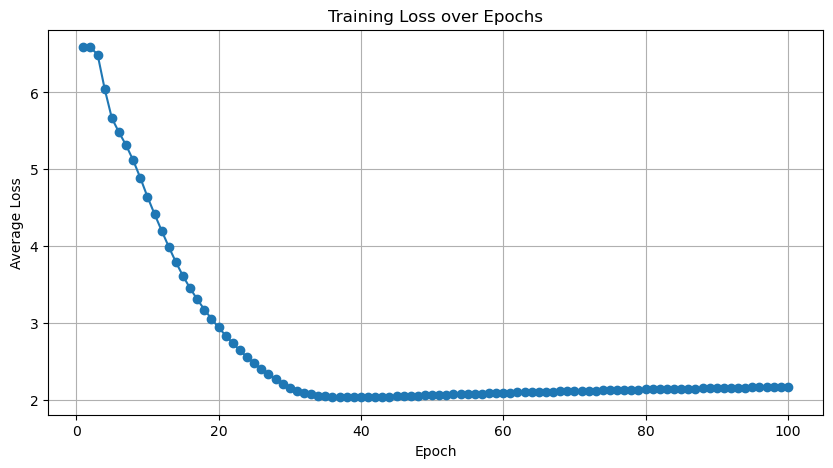

In [13]:
model,word2idx=train_example(vocab=vocab,training_pairs=word_pairs,epochs=100,learning_rate=0.1)

In [14]:

embeddings = extract_embeddings(model, word2idx)
with open('word_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [15]:
import pickle
with open('skipgram_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [16]:
similarity_df = compute_cosine_similarity(embeddings)
word = 'business'
top_similar = get_top_n_similar(similarity_df, word, top_n=5)
print(f"Top 5 words similar to '{word}':")
for similar_word, score in top_similar:
    print(f"{similar_word}: {score:.4f}")

Top 5 words similar to 'business':
struggles: 0.8169
design: 0.7672
financial: 0.6998
says: 0.5568
host: 0.4925


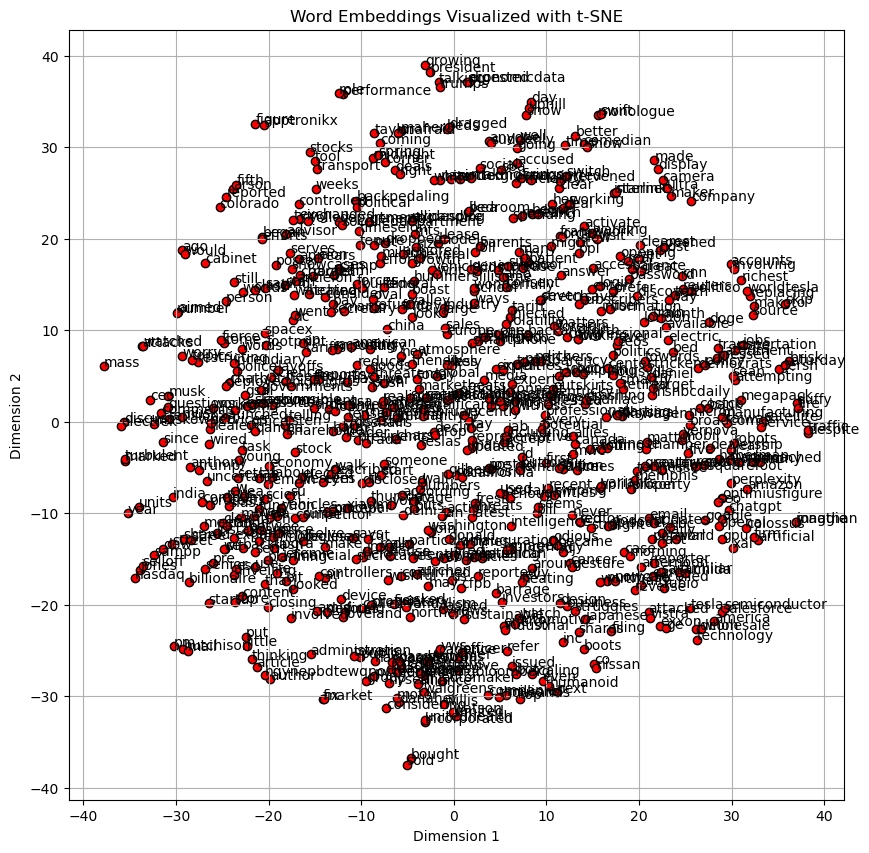

In [17]:
plot_embeddings_tsne(embeddings)